# Assignment 3

Name: LU Zetian

SID: 20777702

## Problem 1

Given $z_i \mid \mu_i \sim \mathcal{N}(\mu_i, 1), i = 1, ..., n$. Let $\gamma_i$ be an indicator, assume

$$
\begin{cases} 
    \mu_i \sim \mathcal{N}(0, \sigma^2), & \text{if $\gamma_i = 1$} \\
    \mu_i = 0, & \text{if $\gamma_i = 0$}
\end{cases}
$$

Let $\pi = \mathbb{P}(\gamma_i = 1)$ and $1 - \pi = \mathbb{P}(\gamma_i = 0)$. 

### (a)

From the given model, we know

$$
\begin{cases} 
    z_i \sim \mathcal{N}(0, 1 + \sigma^2), & \text{if $\gamma_i = 1$} \\
    z_i \sim \mathcal{N}(0, 1), & \text{if $\gamma_i = 0$}
\end{cases}
$$

Thus, $z_i$ follows a distribution with a mix of two Gaussian components:

$$ z_i \sim (1 - \pi) \mathcal{N}(0, 1) + \pi \mathcal{N}(0, 1 + \sigma^2) $$

We can estimate $\pi$ and $\sigma^2$ through an EM algorithm. 

First, initialize $\pi^{(0)} \in (0, 1)$ and $\sigma^{2(0)} > 0$. We can simply set $\pi^{(0)} = 0.5$ and $\sigma^{2(0)} = 1$. 

Then we keep iterating the following procedures until convergence. Assuming we are at iteration $k$. 

**Expectation step:**

Let $\tau = 1 + \sigma^2$ and 

$$w_i^{(k)} = \mathbb{E}[\gamma_i \mid z_i, \pi^{(k)}, \tau^{(k)}] = \mathbb{P}(\gamma_i = 1 \mid z_i, \pi^{(k)}, \tau^{(k)})$$

By Bayes' theorem, we have

$$ w_i^{(k)} = \frac{\pi^{(k)} f(z_i \mid \gamma_i = 1, \tau^{(k)})}{\pi^{(k)} f(z_i \mid \gamma_i = 1, \tau^{(k)}) + (1 - \pi^{(k)}) f(z_i \mid \gamma_i = 0, \tau^{(k)})} $$

where

$$f_0^{(k)}(z_i) = f(z_i \mid \gamma_i = 0, \tau^{(k)}) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{1}{2} z_i^2}$$

and

$$f_1^{(k)}(z_i) = f(z_i \mid \gamma_i = 1, \tau^{(k)}) = \frac{1}{\sqrt{2 \pi \tau^{(k)}}} e^{-\frac{z_i^2}{2 \tau^{(k)}}}$$

Thus

$$ w_i^{(k)} = \frac{\pi^{(k)} f_1^{(k)}(z_i)}{\pi^{(k)} f_1^{(k)}(z_i) + (1 - \pi^{(k)}) f_0^{(k)}(z_i)} $$

**Maximization step:**

Through a maximum likelihood estimation (MLE), we can compute $\pi^{(k+1)}$ and $\tau^{(k+1)}$ for updates. The exact formula is given by:

$$\pi^{(k+1)} = \frac{\sum_{i=1}^n w_i^{(k)}}{n}$$

and 

$$\tau^{(k+1)} = \frac{\sum_{i=1}^n w_i^{(k)} z_i^2}{\sum_{i=1}^n w_i^{(k)}}$$

Then we can estimate $\sigma^{2(k+1)} = \tau^{(k+1)}$. 

We iterate this process until it converges, that is, the update of $\pi^{(k)}$ and $\sigma^{2(k)}$ is very small. 

Let $K$ be the iteration we stop, we have $\hat{\pi} = \pi^{(K)}$, $\hat{\sigma}^2 = \sigma^{2(K)}$ and $\hat{w}_i = w_i^{(K)}$. 

The posterior mean of $\mu_i$

$$\mathbb{E}[\mu_i \mid z_i] = \mathbb{E}[\mu_i \mid z_i, \gamma_i = 1] \cdot \mathbb{P}(\gamma_i = 1 \mid z_i) + \mathbb{E}[\mu_i \mid z_i, \gamma_i = 0] \cdot \mathbb{P}(\gamma_i = 0 \mid z_i)$$

Since $\mathbb{E}[\mu_i \mid z_i, \gamma_i = 0] = 0$, 

$$\mathbb{E}[\mu_i \mid z_i] = \mathbb{E}[\mu_i \mid z_i, \gamma_i = 1] \cdot \mathbb{P}(\gamma_i = 1 \mid z_i) = \hat{w}_i \, \mathbb{E}[\mu_i \mid z_i, \gamma_i = 1]$$

Notice that $\mathbb{E}[\mu_i \mid z_i, \gamma_i = 1]$ is just the James Stein Estimator, thus we have $\hat\mu_i^S = \hat{w}_i \frac{\hat\sigma^2}{1 + \hat\sigma^2} z_i$. 

### (b)



pi=0.100: mix=0.0975, js=0.1000, tweedie=0.1371
pi=0.189: mix=0.1557, js=0.1639, tweedie=0.2064
pi=0.278: mix=0.2153, js=0.2268, tweedie=0.2554
pi=0.367: mix=0.2572, js=0.2686, tweedie=0.2982
pi=0.456: mix=0.2963, js=0.3087, tweedie=0.3366
pi=0.544: mix=0.3481, js=0.3574, tweedie=0.3776
pi=0.633: mix=0.3764, js=0.3821, tweedie=0.4174
pi=0.722: mix=0.4163, js=0.4210, tweedie=0.4455
pi=0.811: mix=0.4541, js=0.4541, tweedie=0.4841
pi=0.900: mix=0.4677, js=0.4672, tweedie=0.4884


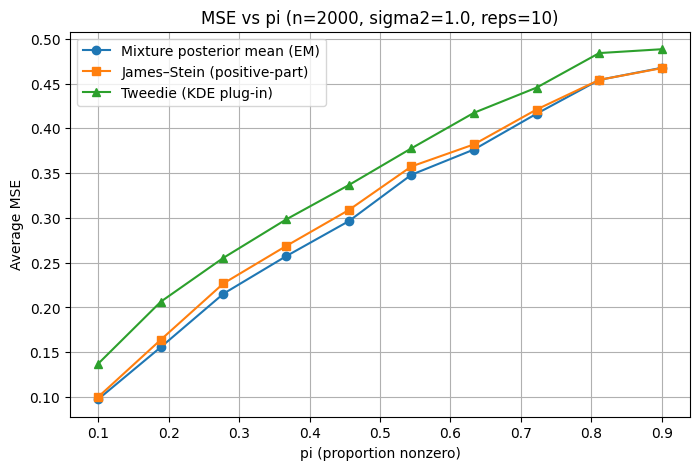

In [1]:
# Simulation comparing three estimators under spike-and-slab prior
# - Mixture posterior mean (EM-fitted)
# - James–Stein estimator
# - Tweedie's formula estimator (plug-in using KDE for marginal density)

import numpy as np
from numpy.linalg import norm
from scipy.stats import norm as snorm
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

n = 2000         # number of coordinates per replication
sigma2_true = 1.0  # variance of nonzero signals
reps = 10        # number of Monte Carlo replications

# --- Helper: EM to estimate (pi, sigma2) from observed z ---
def em_fit(z, max_iter=200, tol=1e-6, pi0=0.5, sigma20=1.0):
    pi = np.clip(pi0, 1e-6, 1-1e-6)
    sigma2 = max(sigma20, 1e-6)
    for _ in range(max_iter):
        tau = 1.0 + sigma2
        f0 = snorm.pdf(z, loc=0, scale=1.0)
        f1 = snorm.pdf(z, loc=0, scale=np.sqrt(tau))
        w = (pi * f1) / (pi * f1 + (1 - pi) * f0)
        pi_new = w.mean()
        # Avoid division by 0
        wsum = w.sum()
        if wsum < 1e-8:
            break
        tau_new = (w @ (z**2)) / wsum
        sigma2_new = max(tau_new - 1.0, 1e-8)
        if abs(pi_new - pi) < tol and abs(sigma2_new - sigma2) < tol:
            pi, sigma2 = pi_new, sigma2_new
            break
        pi, sigma2 = pi_new, sigma2_new
    return pi, sigma2, w

# --- Estimators ---
# 1) Mixture posterior mean: E[mu|z] = w * (sigma2/(1+sigma2)) * z
#    using EM-fitted (pi, sigma2) and corresponding w
def mixture_posterior_mean(z, pi_hat, sigma2_hat):
    tau = 1.0 + sigma2_hat
    f0 = snorm.pdf(z, 0, 1.0)
    f1 = snorm.pdf(z, 0, np.sqrt(tau))
    w = (pi_hat * f1) / (pi_hat * f1 + (1 - pi_hat) * f0)
    shrink = sigma2_hat / (1.0 + sigma2_hat)
    return w * shrink * z

# 2) James–Stein estimator (positive-part), applied coordinate-wise grouping
# JS is typically for d>=3 Gaussian mean vector with known variance 1.
# We apply the classic positive-part JS toward 0 across the n coordinates:
#   mu_hat_JS = (1 - (n-2)/||z||^2)_+ * z
def james_stein(z):
    d = z.size
    s2 = norm(z)**2
    factor = max(0.0, 1.0 - (d - 2.0) / s2)
    return factor * z

# 3) Tweedie's formula: E[mu|z] = z + d/dz log f_Z(z), with f_Z the marginal of z
# We'll estimate f_Z using a KDE and compute derivative via score function from KDE.
# gaussian_kde provides logpdf and score_samples (in newer SciPy); if absent, we approximate.
def tweedie_estimate(z):
    kde = gaussian_kde(z)
    # Score: derivative of log f = f'/f. gaussian_kde exposes evaluate and we can approximate derivative numerically.
    # Use central differences on a per-point basis with a small h based on bandwidth.
    bw = np.sqrt(kde.covariance.squeeze())
    h = 1e-3 * max(bw, 1e-3)
    f = kde.evaluate(z)
    f_plus = kde.evaluate(z + h)
    f_minus = kde.evaluate(z - h)
    # numerical derivative of log f
    with np.errstate(divide='ignore', invalid='ignore'):
        dlogf = ((np.log(f_plus) - np.log(f_minus)) / (2*h))
    dlogf = np.where(np.isfinite(dlogf), dlogf, 0.0)
    return z + dlogf

# --- Single replication ---
def one_replication(n, pi, sigma2):
    gamma = rng.random(n) < pi
    mu = np.zeros(n)
    mu[gamma] = rng.normal(0.0, np.sqrt(sigma2), size=gamma.sum())
    z = mu + rng.normal(0.0, 1.0, size=n)

    # Fit EM for mixture estimator
    pi_hat, sigma2_hat, _ = em_fit(z)
    mu_hat_mix = mixture_posterior_mean(z, pi_hat, sigma2_hat)

    # James–Stein
    mu_hat_js = james_stein(z)

    # Tweedie (plug-in via KDE)
    mu_hat_tw = tweedie_estimate(z)

    # MSEs
    mse_mix = np.mean((mu_hat_mix - mu)**2)
    mse_js = np.mean((mu_hat_js - mu)**2)
    mse_tw = np.mean((mu_hat_tw - mu)**2)
    return mse_mix, mse_js, mse_tw

# --- Sweep pi and collect MSEs ---
pi_grid = np.linspace(0.1, 0.9, 10)
mse_mix_mean = []
mse_js_mean = []
mse_tw_mean = []

for pi_true in pi_grid:
    mse_mix_list, mse_js_list, mse_tw_list = [], [], []
    for _ in range(reps):
        m1, m2, m3 = one_replication(n, pi_true, sigma2_true)
        mse_mix_list.append(m1)
        mse_js_list.append(m2)
        mse_tw_list.append(m3)
    mse_mix_mean.append(np.mean(mse_mix_list))
    mse_js_mean.append(np.mean(mse_js_list))
    mse_tw_mean.append(np.mean(mse_tw_list))
    print(f"pi={pi_true:.3f}: mix={mse_mix_mean[-1]:.4f}, js={mse_js_mean[-1]:.4f}, tweedie={mse_tw_mean[-1]:.4f}")

# --- Plot MSE vs pi ---
plt.figure(figsize=(8,5))
plt.plot(pi_grid, mse_mix_mean, marker='o', label='Mixture posterior mean (EM)')
plt.plot(pi_grid, mse_js_mean, marker='s', label='James–Stein (positive-part)')
plt.plot(pi_grid, mse_tw_mean, marker='^', label='Tweedie (KDE plug-in)')
plt.xlabel('pi (proportion nonzero)')
plt.ylabel('Average MSE')
plt.title(f'MSE vs pi (n={n}, sigma2={sigma2_true}, reps={reps})')
plt.legend()
plt.grid(True)
plt.show()


### (c)

For fixed $\sigma^2 = 1$. Given a new observed vector $\mathbf{a} = [a_1, ..., a_n]^T$ which is related to $\mathbf{\gamma}$ and the relationship is

$$\log \frac{p(\gamma_i = 1 \mid a_i)}{p(\gamma_i = 0 \mid a_i)} = \beta_0 + \beta a_i$$

Since the event $\gamma_i = 1$ is now conditioned on observed vector $\mathbf{a}$, denote $\pi_i = p(\gamma_i = 1 \mid a_i)$, and so $1 - \pi_i = p(\gamma_i = 0 \mid a_i)$. Then we have

$$ z_i \sim (1 - \pi_i) \mathcal{N}(0, 1) + \pi_i \mathcal{N}(0, 2) $$

and 

$$p(z_i \mid a_i, \beta_0, \beta) = (1 - \pi_i) \phi(z_i; 0, 1) + \pi_i \phi(z_i; 0, 2)$$

where $\phi(z; \mu, v) = \frac{1}{\sqrt{2\pi v}} \exp\left(-\frac{(z - \mu)^2}{2v}\right)$. 

Again, we can estimate $\beta_0$ and $\beta$ through an EM algorithm, and the process is very similar to (a). 

First, we initialize $\beta_0^{(0)}$ and $\beta^{(0)}$, for example, set $\beta_0^{(0)} = 0$, $\beta^{(0)} = 0$. Then we begin the EM iteration. 

**Expectation step (iteration $k$):**

The $Q$ function:

$$
\begin{align*}
Q &= \mathbb{E}[\sum_{i=1}^n \log \left(P(z_i, \gamma_i \mid a_i; \beta_0, \beta) \right] \mid z_i, a_i, \beta_0^{(k)}, \beta^{(k)}) \\
&= \mathbb{E}[\sum_{i=1}^n \log \left(P(\gamma_i \mid a_i, \beta_0, \beta) f(z_i \mid \gamma_i) \right] \mid z_i, a_i, \beta_0^{(k)}, \beta^{(k)}) \\
&= \mathbb{E}[\sum_{i=1}^n \gamma_i \log \left(\text{Sigmoid}(\beta_0 + \beta a_i) \phi(z_i; 0, 2) \right) + (1 - \gamma_i) \log \left((1 - \text{Sigmoid}(\beta_0 + \beta a_i)) \phi(z_i; 0, 1) \right) \mid z_i, a_i, \beta_0^{(k)}, \beta^{(k)}]
\end{align*}
$$

Let $w_i^{(k)} = P(\gamma_i = 1 \mid z_i, a_i; \beta_0^{(k)}, \beta^{(k)})$, we have

$$w_i^{(k)} = \frac{\pi_i^{(k)} \phi(z_i; 0, 2)}{\pi_i^{(k)} \phi(z_i; 0, 2) + (1 - \pi_i^{(k)}) \phi(z_i; 0, 1)}$$

where $\pi^{(k)} = \text{Sigmoid}(\beta_0^{(k)} + \beta^{(k)} a_i)$, then

$$Q = \sum_{i=1}^n w_i^{(k)} \log \left(\text{Sigmoid}(\beta_0 + \beta a_i) \phi(z_i; 0, 2) \right) + (1 - w_i^{(k)}) \log \left((1 - \text{Sigmoid}(\beta_0 + \beta a_i)) \phi(z_i; 0, 1) \right)$$

**Maximization step:**

We want to update $\beta_0^{(k)}$ and $\beta^{(k)}$ by

$$
\begin{align*}
(\beta_0^{(k+1)}, \beta^{(k+1)}) &= \arg\max_{\beta_0, \beta} Q \\
&= \arg\max_{\beta_0, \beta} \sum_{i=1}^n w_i^{(k)} \log (\text{Sigmoid}(\beta_0 + \beta a_i)) + (1 - w_i^{(k)}) \log (1 - \text{Sigmoid}(\beta_0 + \beta a_i)) \\
&= \arg\max_{\beta_0, \beta} \sum_{i=1}^n w_i^{(k)} (\beta_0 + \beta a_i) + \log (1 + e^{\beta_0 + \beta a_i})
\end{align*}
$$

This can be done through numerical optimization algorithms. 

We repeat this process until convergence, then we can have the etimated $\hat\beta_0$ and $\hat\beta$. 

To test whether $\beta = 0$, we can do a likelihood ratio test, where

$$\ell_0 = \sum_{i=1}^n \log \left[ (1 - \pi) \phi(z_i; 0, 1) + \pi \phi(z_i; 0, 2) \right]$$

and 

$$\ell_1 = \sum_{i=1}^n \log \left[ (1 - \sigma(\hat{\beta}_0 + \hat{\beta} a_i)) \phi(z_i; 0, 1) + \sigma(\hat{\beta}_0 + \hat{\beta} a_i) \phi(z_i; 0, 2) \right]$$

The statistic

$$D = 2 (\ell_1 - \ell_0)$$

Under null hypothesis ($\beta = 0$), $D \sim \mathcal{X}_1^2$. Then we can do a statistic test. 

$p(\gamma_i \mid z_i, a_i, \beta_0, \beta)$ is simply given by $w_i^{(K)}$, where $K$ is the last iteration of the EM algorithm. 

The posterior mean is

$$\mathbb{E}[\mu_i \mid z_i, a_i] = \mathbb{E}[\mu_i \mid z_i, \gamma_i = 1] P(\gamma_i = 1 \mid z_i, a_i) + \mathbb{E}[\mu_i \mid z_i, \gamma_i = 0] P(\gamma_i = 0 \mid z_i, a_i) = w_i^{(K)} \frac{z_i}{2}$$

beta=-5.00: MSE c6=0.29618, MSE c3=0.30215,   c6 better? True
beta=-4.50: MSE c6=0.28850, MSE c3=0.29500,   c6 better? True
beta=-4.00: MSE c6=0.28815, MSE c3=0.29218,   c6 better? True
beta=-3.50: MSE c6=0.27910, MSE c3=0.28571,   c6 better? True
beta=-3.00: MSE c6=0.27378, MSE c3=0.27778,   c6 better? True
beta=-2.50: MSE c6=0.26732, MSE c3=0.26907,   c6 better? True
beta=-2.00: MSE c6=0.25587, MSE c3=0.25914,   c6 better? True
beta=-1.50: MSE c6=0.26260, MSE c3=0.26094,   c6 better? False
beta=-1.00: MSE c6=0.24109, MSE c3=0.23880,   c6 better? False
beta=-0.50: MSE c6=0.23653, MSE c3=0.23303,   c6 better? False
beta=0.00: MSE c6=0.23330, MSE c3=0.22518,   c6 better? False
beta=0.50: MSE c6=0.24686, MSE c3=0.24296,   c6 better? False
beta=1.00: MSE c6=0.24686, MSE c3=0.24478,   c6 better? False
beta=1.50: MSE c6=0.25922, MSE c3=0.25916,   c6 better? False
beta=2.00: MSE c6=0.26183, MSE c3=0.26055,   c6 better? False
beta=2.50: MSE c6=0.26272, MSE c3=0.26237,   c6 better? False
beta=

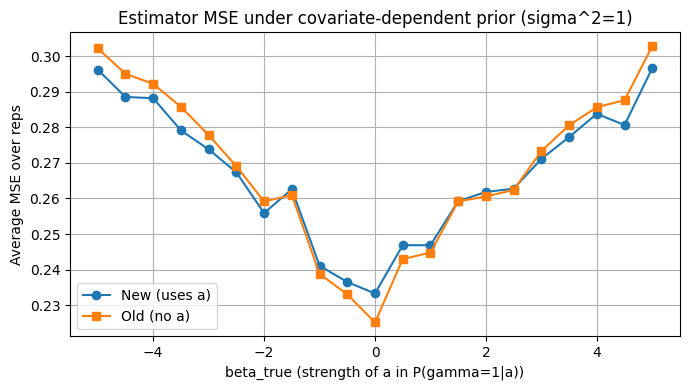

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Helpers ----------------

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def normal_pdf(x, var):
    # N(0, var) density
    return (1.0 / np.sqrt(2.0 * np.pi * var)) * np.exp(-0.5 * (x**2) / var)

# EM for global mixture ignoring covariates
# Returns: pi_hat, sigma2_hat

def em_global(z, max_iter=200, tol=1e-6, pi0=0.5, sigma20=1.0):
    z = np.asarray(z)
    pi = float(np.clip(pi0, 1e-6, 1-1e-6))
    sigma2 = float(max(sigma20, 1e-8))
    for _ in range(max_iter):
        tau = 1.0 + sigma2
        f0 = normal_pdf(z, 1.0)
        f1 = normal_pdf(z, tau)
        denom = pi * f1 + (1.0 - pi) * f0 + 1e-300
        w = (pi * f1) / denom
        pi_new = w.mean()
        wsum = w.sum()
        if wsum < 1e-12:
            break
        tau_new = (w @ (z**2)) / wsum
        sigma2_new = max(tau_new - 1.0, 1e-8)
        if abs(pi_new - pi) < tol and abs(sigma2_new - sigma2) < tol:
            pi, sigma2 = pi_new, sigma2_new
            break
        pi, sigma2 = pi_new, sigma2_new
    return pi, sigma2

# Logistic-EM for (beta0, beta) with soft labels w from E-step
# Maximizes sum_i [ w_i log(sigmoid(eta_i)) + (1-w_i) log(1 - sigmoid(eta_i)) ] via IRLS

def logistic_em(z, a, max_em_iter=100, tol=1e-6, newton_steps=5, ridge=1e-6):
    z = np.asarray(z)
    a = np.asarray(a)
    n = z.size
    beta0, beta = 0.0, 0.0
    X = np.column_stack([np.ones(n), a])

    for _ in range(max_em_iter):
        # E-step: compute soft gamma posteriors w using current (beta0, beta)
        eta = beta0 + beta * a
        pi_i = sigmoid(eta)
        f0 = normal_pdf(z, 1.0)
        f1 = normal_pdf(z, 2.0)  # since sigma^2 = 1 fixed in (c) => tau = 2
        denom = pi_i * f1 + (1.0 - pi_i) * f0 + 1e-300
        w = (pi_i * f1) / denom

        # M-step: IRLS/Newton for weighted logistic with soft targets w
        for _ in range(newton_steps):
            eta = X @ np.array([beta0, beta])
            pi_i = sigmoid(eta)
            W = pi_i * (1.0 - pi_i)  # shape (n,)
            # Positive-definite Hessian for ascent: Hpos = X^T W X
            Hpos = X.T @ (W[:, None] * X)
            grad = X.T @ (w - pi_i)
            # Ridge for numerical stability
            Hpos_reg = Hpos + ridge * np.eye(2)
            try:
                delta = np.linalg.solve(Hpos_reg, grad)
            except np.linalg.LinAlgError:
                delta = np.linalg.lstsq(Hpos_reg, grad, rcond=None)[0]
            beta0 += float(delta[0])
            beta += float(delta[1])
            if np.linalg.norm(delta) < 1e-8:
                break
        if np.linalg.norm(delta) < tol:
            break

    # Final w with learned (beta0, beta)
    eta = beta0 + beta * a
    pi_i = sigmoid(eta)
    f0 = normal_pdf(z, 1.0)
    f1 = normal_pdf(z, 2.0)
    denom = pi_i * f1 + (1.0 - pi_i) * f0 + 1e-300
    w = (pi_i * f1) / denom
    return beta0, beta, w

# Estimator new (covariate-informed): E[mu|z,a] = w * z / 2

def estimator_new(z, a):
    _, _, w = logistic_em(z, a)
    return 0.5 * w * z

# Estimator old (no covariates): E[mu|z] = w * (sigma2/(1+sigma2)) * z

def estimator_old(z):
    pi_hat, sigma2_hat = em_global(z)
    tau = 1.0 + sigma2_hat
    f0 = normal_pdf(z, 1.0)
    f1 = normal_pdf(z, tau)
    denom = pi_hat * f1 + (1.0 - pi_hat) * f0 + 1e-300
    w = (pi_hat * f1) / denom
    shrink = sigma2_hat / (1.0 + sigma2_hat)
    return shrink * w * z

# ---------------- Simulation ----------------

def simulate_compare(n=1000, reps=10, beta_grid=(-5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0), pi_base=0.3, seed=42):
    rng = np.random.default_rng(seed)
    def logit(p):
        return np.log(p) - np.log(1.0 - p)

    mse_new = []
    mse_old = []

    for beta_true in beta_grid:
        mse_new_list, mse_old_list = [], []
        # Choose beta0 to target base prevalence approximately
        beta0_true = float(logit(pi_base))
        for _ in range(reps):
            a = rng.normal(0.0, 1.0, size=n)
            pi_i = sigmoid(beta0_true + beta_true * a)
            gamma = rng.random(n) < pi_i
            mu = np.zeros(n)
            # sigma^2 fixed to 1 in (c)
            mu[gamma] = rng.normal(0.0, 1.0, size=int(gamma.sum()))
            z = mu + rng.normal(0.0, 1.0, size=n)

            mu_hat_new = estimator_new(z, a)
            mu_hat_old = estimator_old(z)

            mse_new_list.append(np.mean((mu_hat_new - mu) ** 2))
            mse_old_list.append(np.mean((mu_hat_old - mu) ** 2))
        mse_new.append(np.mean(mse_new_list))
        mse_old.append(np.mean(mse_old_list))
        print(f"beta={beta_true:.2f}: MSE c6={mse_new[-1]:.5f}, MSE c3={mse_old[-1]:.5f},   c6 better? {mse_new[-1] < mse_old[-1]}")

    return np.array(beta_grid), np.array(mse_new), np.array(mse_old)

# Run and plot
beta_grid, mse_new, mse_old = simulate_compare()
plt.figure(figsize=(7,4))
plt.plot(beta_grid, mse_new, marker='o', label='New (uses a)')
plt.plot(beta_grid, mse_old, marker='s', label='Old (no a)')
plt.xlabel('beta_true (strength of a in P(gamma=1|a))')
plt.ylabel('Average MSE over reps')
plt.title('Estimator MSE under covariate-dependent prior (sigma^2=1)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Problem 2

Given $\mathbf{y} = \mathbf{X} \mathbf{b} + \mathbf{e}$, with $\mathbf{e} \sim \mathcal{N}(0, \sigma^2 \mathbf{I})$. 

Suppose there is only one non-zero coefficient in $\mathbf{b}$, write $\mathbf{b} = b \mathbf{\gamma}$, where $b$ is a scaler and $\mathbf{\gamma}$ is a $p \times 1$ binary vector. Assume $b \sim \mathcal{N}(0, \sigma_0^2)$ and $p(\gamma_i = 1) = \frac{1}{p}$. 

To estimate $\sigma^2$ and $\sigma_0^2$, we can use an EM algorithm. 

First initialize $\sigma^{2(0)} > 0$ and $\sigma_0^{2(0)} > 0$. Assume we are at iteration $k$. 

**Expectation step:**

The expectation we want to compute is

$$\mathbb{E}_{\gamma \sim p(\gamma \mid \mathbf{y}, \sigma^{2(k-1)}, \sigma_0^{2(k-1)})} \left[ \log p(\mathbf{y}, \gamma \mid \sigma^2, \sigma_0^2) \right] = \sum_{i=1}^p p(\gamma_i = 1 \mid \mathbf{y}, \sigma^{2(k-1)}, \sigma_0^{2(k-1)}) \, \log p(\mathbf{y}, \gamma_i = 1 \mid \sigma^2, \sigma_0^2)$$

Let $\tau_i^{(k)} = p(\gamma_i = 1 \mid \mathbf{y}, \sigma^{2(k-1)}, \sigma_0^{2(k-1)})$, we have

$$
\begin{align*}
\mathbb{E}_{\gamma \sim p(\gamma \mid \mathbf{y}, \sigma^{2(k-1)}, \sigma_0^{2(k-1)})} \left[ \log p(\mathbf{y}, \gamma \mid \sigma^2, \sigma_0^2) \right] 
&= \sum_{i=1}^p \tau_i^{(k)} \, \log p(\mathbf{y}, \gamma_i = 1 \mid \sigma^2, \sigma_0^2) \\
&= \sum_{i=1}^p \tau_i^{(k)} \, \log (p(\mathbf{y} \mid \gamma_i = 1,  \sigma^2, \sigma_0^2) p(\gamma_i = 1))
\end{align*}
$$

Since $p(\gamma_i = 1) = \frac{1}{p}$, we have 

$$\mathbb{E}_{\gamma \sim p(\gamma \mid \mathbf{y}, \sigma^{2(k-1)}, \sigma_0^{2(k-1)})} \left[ \log p(\mathbf{y}, \gamma \mid \sigma^2, \sigma_0^2) \right] = \sum_{i=1}^p \tau_i^{(k)} \, \log (p(\mathbf{y} \mid \gamma_i = 1,  \sigma^2, \sigma_0^2) \cdot \frac{1}{p})$$

By Bayes' theorem, we have

$$
\begin{align*}
\tau_i^{(k)} 
&= \frac{p(\gamma_i = 1, \mathbf{y} \mid \sigma^{2(k-1)}, \sigma_0^{2(k-1)})}{p(\mathbf{y} \mid \sigma^{2(k-1)}, \sigma_0^{2(k-1)})} \\
&= \frac{p(\gamma_i = 1, \mathbf{y} \mid \sigma^{2(k-1)}, \sigma_0^{2(k-1)})}{\sum_{j=1}^p p(\gamma_j = 1, \mathbf{y} \mid \sigma^{2(k-1)}, \sigma_0^{2(k-1)})} \\
&= \frac{p(\mathbf{y} \mid \gamma_i = 1, \sigma^{2(k-1)}, \sigma_0^{2(k-1)})}{\sum_{j=1}^p p(\mathbf{y} \mid \gamma_j = 1, \sigma^{2(k-1)}, \sigma_0^{2(k-1)})}
\end{align*}
$$

Notice that $p(\mathbf{y} \mid \gamma_i = 1, \sigma^{2(k-1)}, \sigma_0^{2(k-1)})$ is the probability density function (pdf) of the normal distribution $\mathcal{N}(0, \sigma_0^{2(k-1)} x_i^T x_i + \sigma^{2(k-1)} \mathbf{I})$. Thus we can compute $\mathbb{E}_{\gamma \sim p(\gamma \mid \mathbf{y}, \sigma^{2(k-1)}, \sigma_0^{2(k-1)})} \left[ \log p(\mathbf{y}, \gamma \mid \sigma^2, \sigma_0^2) \right]$ for the maximization step. 

**Maximization step:**

We can optimize parameters $\sigma^{2(k)}$ and $\sigma_0^{2(k)}$ by

$$
\begin{align*}
(\sigma^{2(k)}, \sigma_0^{2(k)}) 
&= \arg\max_{\sigma^2, \sigma_0^2} \sum_{i=1}^p \tau_i^{(k)} \, \log (p(\mathbf{y} \mid \gamma_i = 1,  \sigma^2, \sigma_0^2) \cdot \frac{1}{p}) \\
&= \arg\max_{\sigma^2, \sigma_0^2} \sum_{i=1}^p \tau_i^{(k)} \, \log p(\mathbf{y} \mid \gamma_i = 1,  \sigma^2, \sigma_0^2)
\end{align*}
$$

We can repeat the above steps until $\tau_i^{(K)}$ convergence at interation $K$, and we can then get $\hat\sigma^2$ and $\hat\sigma_0^2$ from $\tau_i^{(K)}$. The posterior of $\gamma$, which is $p(\gamma_i | \mathbf{X}, \mathbf{y}, \sigma^2, \sigma_0^2)$, is simply $\tau_i^{(K)}$. 

Now we derive $p(b \mid \mathbf{X}, \mathbf{y}, \sigma^2, \sigma_0^2, \gamma_i = 1)$. By Bayes' rule, 

$$p(b \mid \mathbf{X}, \mathbf{y}, \sigma^2, \sigma_0^2, \gamma_i = 1) \propto p(\mathbf{y} \mid b, \mathbf{X}, \sigma^2, \gamma_i = 1) \, p(b \mid \sigma_0^2)$$

Since $p(b \mid \sigma_0^2)$ is the pdf of $\mathcal{N}(0, \sigma_0^2)$ and $p(\mathbf{y} \mid b, \mathbf{X}, \sigma^2, \gamma_i = 1)$ is the pdf of $\mathcal{N}(b x_i, \sigma^2 \mathbf{I})$,

$$
\begin{align*}
\log p(b \mid \mathbf{y}, \mathbf{X}, \sigma_0^2, \sigma^2, \gamma_i = 1) 
& \propto -\frac{1}{2\sigma^2} \left( \mathbf{y}^T \mathbf{y} - 2 b \mathbf{x}_i^T \mathbf{y} + b^2 \|\mathbf{x}_i\|^2 \right) - \frac{1}{2\sigma_0^2} b^2 \\
& \propto -\frac{1}{2\sigma^2} \left(- 2 b \mathbf{x}_i^T \mathbf{y} + b^2 \|\mathbf{x}_i\|^2 \right) - \frac{1}{2\sigma_0^2} b^2
\end{align*}
$$

By completing the square:

$$
\begin{align*}
-\frac{1}{2\sigma^2} \left(- 2 b \mathbf{x}_i^T \mathbf{y} + b^2 \|\mathbf{x}_i\|^2 \right) - \frac{1}{2\sigma_0^2} b^2 
&= -\frac{1}{2}(\frac{\|\mathbf{x}_i\|^2}{\sigma^2} + \frac{1}{\sigma_0^2})(b - \frac{\frac{\mathbf{x}_i^T \mathbf{y}}{\sigma^2}}{\frac{\|\mathbf{x}_i\|^2}{\sigma^2} + \frac{1}{\sigma_0^2}})^2 + \frac{(\frac{\mathbf{x}_i^T \mathbf{y}}{\sigma^2})^2}{2(\frac{\|\mathbf{x}_i\|^2}{\sigma^2} + \frac{1}{\sigma_0^2})} \\
&\propto -\frac{1}{2}(\frac{\|\mathbf{x}_i\|^2}{\sigma^2} + \frac{1}{\sigma_0^2})(b - \frac{\frac{\mathbf{x}_i^T \mathbf{y}}{\sigma^2}}{\frac{\|\mathbf{x}_i\|^2}{\sigma^2} + \frac{1}{\sigma_0^2}})^2
\end{align*}
$$

Thus we can see that $p(b \mid \mathbf{y}, \mathbf{X}, \sigma_0^2, \sigma^2, \gamma_i = 1)$ is a Gaussian with variance $v_i^2 = (\frac{\|\mathbf{x}_i\|^2}{\sigma^2} + \frac{1}{\sigma_0^2})^{-1}$ and mean $\mu_i = v_i^2 \cdot \frac{\mathbf{x}_i^T \mathbf{y}}{\sigma^2}$. 


## Problem 3

The author mentioned about boosting with larger trees seems to outperform stumps and has no overfitting problem. The follow simulation shows that it is very likely that the author draw such conclusion due to the use of misclassification error. The method of boosting with larger trees does overfitting on cross entropy loss and exponential loss. 

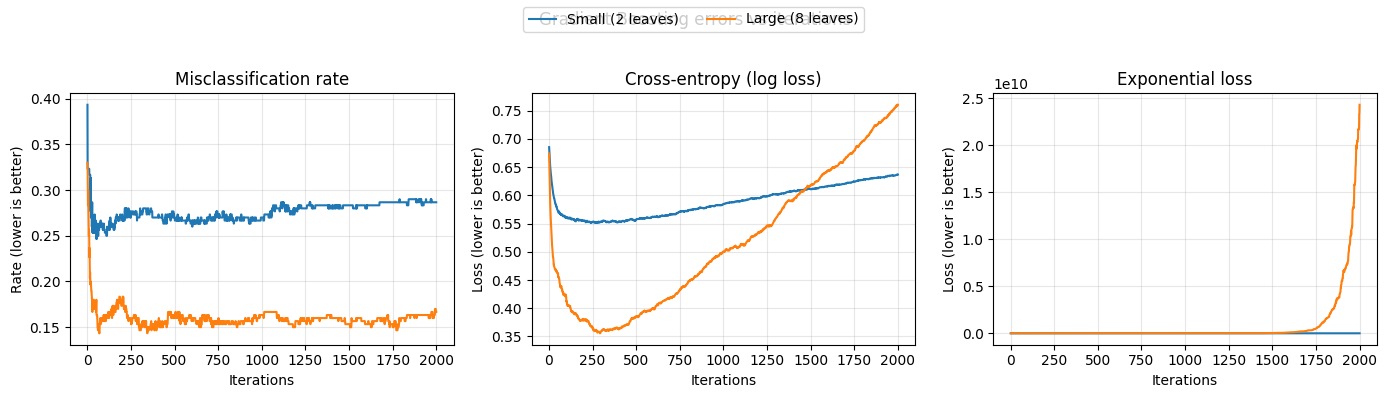

In [3]:
# Gradient Boosting classification: plot errors vs number of iterations
# Compare small trees (2 leaves) vs large trees (8 leaves)
# Metrics:
#  - Misclassification rate (1 - accuracy)
#  - Cross-entropy loss (log loss)
#  - Exponential loss (mean exp(-y f(x)))

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss


def exponential_loss(y_true_binary, scores):
    y_pm = np.where(y_true_binary == 1, 1.0, -1.0)
    return float(np.mean(np.exp(-y_pm * scores)))


# --- Data ---
seed = 2025
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=10,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=2,
    flip_y=0.03,
    class_sep=1.0,
    random_state=seed,
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# --- Models ---
T = 2000  # number of boosting iterations
clf_small = GradientBoostingClassifier(
    loss="log_loss",
    n_estimators=T,
    learning_rate=0.1,
    max_leaf_nodes=2,
    random_state=seed,
)
clf_large = GradientBoostingClassifier(
    loss="log_loss",
    n_estimators=T,
    learning_rate=0.1,
    max_leaf_nodes=8,
    random_state=seed,
)

clf_small.fit(X_train, y_train)
clf_large.fit(X_train, y_train)

iters = np.arange(1, T + 1)

# --- Track metrics across stages ---
mis_small, mis_large = [], []
ce_small, ce_large = [], []
exp_small, exp_large = [], []

for (yp_s, pp_s, df_s), (yp_l, pp_l, df_l) in zip(
    zip(clf_small.staged_predict(X_test), clf_small.staged_predict_proba(X_test), clf_small.staged_decision_function(X_test)),
    zip(clf_large.staged_predict(X_test), clf_large.staged_predict_proba(X_test), clf_large.staged_decision_function(X_test)),
):
    # Small
    mis_small.append(1.0 - accuracy_score(y_test, yp_s))
    ce_small.append(log_loss(y_test, pp_s[:, 1], labels=[0, 1]))
    exp_small.append(exponential_loss(y_test, df_s))
    # Large
    mis_large.append(1.0 - accuracy_score(y_test, yp_l))
    ce_large.append(log_loss(y_test, pp_l[:, 1], labels=[0, 1]))
    exp_large.append(exponential_loss(y_test, df_l))

mis_small = np.array(mis_small)
mis_large = np.array(mis_large)
ce_small = np.array(ce_small)
ce_large = np.array(ce_large)
exp_small = np.array(exp_small)
exp_large = np.array(exp_large)

# --- Plot: 3 panels ---
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(iters, mis_small, label='Small (2 leaves)')
axes[0].plot(iters, mis_large, label='Large (8 leaves)')
axes[0].set_title('Misclassification rate')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('Rate (lower is better)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(iters, ce_small, label='Small (2 leaves)')
axes[1].plot(iters, ce_large, label='Large (8 leaves)')
axes[1].set_title('Cross-entropy (log loss)')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('Loss (lower is better)')
axes[1].grid(True, alpha=0.3)

axes[2].plot(iters, exp_small, label='Small (2 leaves)')
axes[2].plot(iters, exp_large, label='Large (8 leaves)')
axes[2].set_title('Exponential loss')
axes[2].set_xlabel('Iterations')
axes[2].set_ylabel('Loss (lower is better)')
axes[2].grid(True, alpha=0.3)

handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_, loc='upper center', ncol=2)
fig.suptitle('Gradient Boosting errors vs iterations')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Problem 4

The $mtry$ parameter can be regarded as imexplicit regularization because it reduces the model variance by the design of Random Forest algorithm, which is the core of regularization. 

Let $m$ be the number of trees, both Bagging and Random Forest are:

$$T_M(x_i) = \frac{1}{M} \sum_{m=1}^M T_m(x_i)$$

The only difference between Bagging and Random Forest is the training data of each tree $T_m$. 

The variance of the model is given by

$$\text{Var}(T_M) = \text{Var}(\frac{1}{M} \sum_{m=1}^M T_m) = \frac{1}{M^2} \text{Var}(\sum_{m=1}^M T_m) = \frac{1}{M^2} (\sum_{m=1}^M \text{Var}(T_m) + \sum_{m \neq n} \text{Cov}(T_m, T_n))$$

So the variance of the forest is related to the covariance between each tree. In Random Forest algorithm, the training data is created by not only doing boostrap on samples, but also randomly selecting $mtry$ features from the original dataset. Thus the covariance between 2 trees in Random Forest is expected to be lower, and therefore can be regarded as an imexplicit regularization. 

max_features=1: mean tree var=9383.6996, ensemble var=5060.3931, avg corr=0.5309
max_features=4: mean tree var=9360.6939, ensemble var=6647.3081, avg corr=0.7046
max_features=10: mean tree var=9324.3081, ensemble var=7928.6322, avg corr=0.8478
max_features=20: mean tree var=9315.2113, ensemble var=8389.9348, avg corr=0.8992


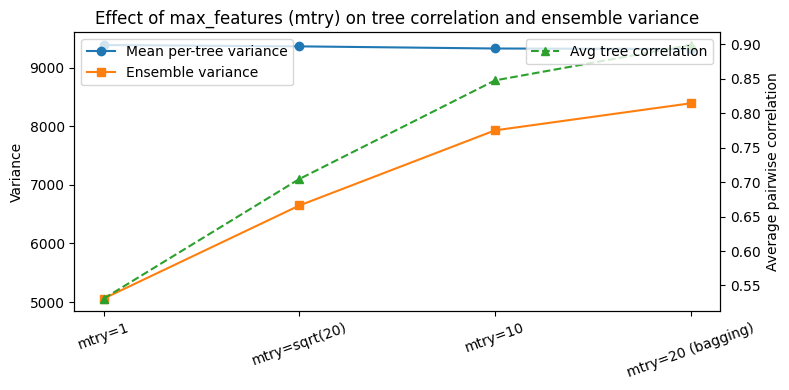

Interpretation: Lower max_features (smaller mtry) typically reduces tree correlation which can lower ensemble variance even if per-tree variance is similar; this demonstrates why mtry acts as implicit regularization.


In [4]:
# Simulation: show effect of mtry (max_features) on tree correlation and ensemble variance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.utils import resample

rng = np.random.default_rng(1)
# Generate a synthetic regression dataset
n_samples = 500
n_features = 20
X, y = make_regression(n_samples=n_samples, n_features=n_features, n_informative=5, noise=2.0, random_state=0)

# Settings
n_trees = 50
max_features_list = [1, int(np.sqrt(n_features)), int(n_features/2), n_features]  # mtry-like settings
labels = ['mtry=1', f'mtry=sqrt({n_features})', f'mtry={n_features//2}', f'mtry={n_features} (bagging)']
results = []

def per_tree_predictions(model, X):
    # Return array shape (n_trees, n_samples) of individual tree predictions
    preds = []
    # RandomForestRegressor stores trees in estimators_ for sklearn >=0.22
    for est in model.estimators_:
        preds.append(est.predict(X))
    return np.vstack(preds)

for mf in max_features_list:
    # Train a Random Forest with specified max_features (mtry). Use bootstrap=True to match RF.
    rf = RandomForestRegressor(n_estimators=n_trees, max_features=mf, bootstrap=True, random_state=0, n_jobs=1)
    rf.fit(X, y)
    tree_preds = per_tree_predictions(rf, X)  # shape (n_trees, n_samples)

    # Per-tree variance (variance across samples, then average across trees)
    per_tree_var = np.var(tree_preds, axis=1, ddof=1)  # var over samples for each tree
    mean_per_tree_var = per_tree_var.mean()

    # Ensemble mean predictions and variance
    ensemble_preds = tree_preds.mean(axis=0)
    var_ensemble = np.var(ensemble_preds, ddof=1)

    # Pairwise correlations between trees (flatten upper triangle)
    # Compute correlation matrix across trees (rows are trees, cols are samples)
    C = np.corrcoef(tree_preds)  # shape (n_trees, n_trees)
    # take upper triangle without diagonal
    iu = np.triu_indices(n_trees, k=1)
    avg_corr = np.nanmean(C[iu])

    results.append({'mf': mf, 'mean_tree_var': mean_per_tree_var, 'ensemble_var': var_ensemble, 'avg_corr': avg_corr})
    print(f'max_features={mf}: mean tree var={mean_per_tree_var:.4f}, ensemble var={var_ensemble:.4f}, avg corr={avg_corr:.4f}')

# Plot results
mfs = [r['mf'] for r in results]
tree_vars = [r['mean_tree_var'] for r in results]
ens_vars = [r['ensemble_var'] for r in results]
corrs = [r['avg_corr'] for r in results]

fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()
x = np.arange(len(mfs))
ax1.plot(x, tree_vars, marker='o', label='Mean per-tree variance')
ax1.plot(x, ens_vars, marker='s', label='Ensemble variance')
ax2.plot(x, corrs, marker='^', color='C2', label='Avg tree correlation', linestyle='--')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=20)
ax1.set_ylabel('Variance')
ax2.set_ylabel('Average pairwise correlation')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Effect of max_features (mtry) on tree correlation and ensemble variance')
plt.tight_layout()
plt.show()

# Small explanatory print
print('Interpretation: Lower max_features (smaller mtry) typically reduces tree correlation which can lower ensemble variance even if per-tree variance is similar; this demonstrates why mtry acts as implicit regularization.')